# Applied Data Analysis with Python
In this notebook, your goal is to estimate a production function for a dairy cow.

A dairy cow produces milk on an annual basis, and we have data on dairy animals and how much they produce in their annual cycle. More specifically, all milk is made up of components: fat, protein, and other solids. Since fat is the most important component in Wisconsin (because its a cheese market), we need to calculate the age at which dairy cows maximize their fat production.

In most dairy science literature, fat is a quadratic function of age (in cycles); if the function is concave, there is a cycle at which fat production is maximized. So our goal is to estimate a production function to calculate the age at which fat is maximized while also controlling for confounding factors. Such confounding factors:
- In the data, some records are taken early in the cycle, which is a problem because our yield is a cumulative measure. The variable "cycle_length" tells us how far into the cycle the cow is. This needs to be considered so as not to compare animals early in the cycle with animals late in the cycle.
- Cows calve different months, and this affects production. This is recorded in the variable "month_of_calving"
- Different animals are milked more intensivelyt than others; specifically, some cows are milked three times in a day instead of twice. The variable "milked_3x" is the proportion of the cycle where they were milked three times.
- Animals, indexed as "i", are also in herds, "G", so it might be worth considering that different farms will manage their own herds differently to confound the effect of age.
- Finally, observations are taken every month; every month, there a variety of economic forces applying to all herds that means we might want to control for the time effects. "month_of_observation" contains the date of the observation as a string in the format YYYY-MM.

So there are two goals:
1. Analyze the size of the herds and their characteristics in our data set.
2. Estimate the production function for a dairy cow using the data.

While analyzing this data, we will have to use the package __pandas__ extensively.

## Data Preparation using pandas
### Reading in data
Read in data using the "read_csv" function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("cowdata.csv").drop_duplicates()
df

G     i  fat_yield  age  cycle_length            test_date  \
0      19  3920        862    4           304  2011-09-03T00:00:00   
1      19  3921        851    4           320  2011-07-02T00:00:00   
2      19  3922       1032    4           340  2011-07-02T00:00:00   
3      19  3923        770    5           283  2013-06-04T00:00:00   
4      19  3923        744    4           290  2012-04-04T00:00:00   
...    ..   ...        ...  ...           ...                  ...   
12507   0     9       1163    3           355  2014-12-08T00:00:00   
12508   0    10        752    2           277  2013-09-09T00:00:00   
12509   0    10        708    1           296  2012-10-08T00:00:00   
12510   0    11        730    1           280  2014-09-08T00:00:00   
12511   0    11        792    1           308  2014-10-06T00:00:00   

       month_of_calving      date_of_calving  milked_3x  
0                    11  2010-11-03T00:00:00        0.0  
1                     8  2010-08-16T00:00:00        0.0  
2                     7  2010-07-27T00:00:00        0.0  
3                     8  2012-08-25T00:00:00        0.0  
4                     6  2011-06-19T00:00:00        0.0  
...                 ...                  ...        ...  
12507                12  2013-12-18T00:00:00        0.0  
12508                12  2012-12-06T00:00:00        0.0  
12509                12  2011-12-17T00:00:00        0.0  
12510                12  2013-12-02T00:00:00        0.0  
12511                12  2013-12-02T00:00:00        0.0  

[12512 rows x 9 columns]

### Data types
Some important types of data are
- float
- int
- datetime
- str
- categorical

float, int, and str are self-explanatory. The object "datetime" is a typical date object, an example of which is "date_of_calving." The object "categorical" is a special dtype used by pandas to store data that are not numeric but are discrete categories. For example, we can convert "month_of_calving" to a categorical because it can only take 12 values.

Looking below, notice that our datetime and categorical variables are right now just "object," which is what pandas calls a string.

In [2]:
df.dtypes

G                     int64
i                     int64
fat_yield             int64
age                   int64
cycle_length          int64
test_date            object
month_of_calving      int64
date_of_calving      object
milked_3x           float64
dtype: object

In [3]:
# Doing some conversion
df['date_of_calving'] = pd.to_datetime(df['date_of_calving'])
df['test_date'] = pd.to_datetime(df['test_date'])

df['month_of_calving'] = pd.Categorical(df['month_of_calving'])

In [4]:
df.dtypes

G                            int64
i                            int64
fat_yield                    int64
age                          int64
cycle_length                 int64
test_date           datetime64[ns]
month_of_calving          category
date_of_calving     datetime64[ns]
milked_3x                  float64
dtype: object

#### Exercise: The group variable "G" is a categorical variable, as is the cow id "i." Convert both of these to categorical variables so the dataframe knows these are not actual integers.

In [5]:
# Solution:
df['G'] = pd.Categorical(df["G"])
df['i'] = pd.Categorical(df["i"])
df.dtypes

G                         category
i                         category
fat_yield                    int64
age                          int64
cycle_length                 int64
test_date           datetime64[ns]
month_of_calving          category
date_of_calving     datetime64[ns]
milked_3x                  float64
dtype: object

### Slicing and dicing
We should only use animals that calved in 2011-06 onward. Using slicing, we can get rid of the observations using our datetime object.

In [6]:
df = df[df.date_of_calving>"2011-05-30"]
df.shape

(10058, 9)

data is a bit smaller now

Typically, we only compare animals that are at least 300 days into their cycle but not more than 400. If we wanted to only look at these animals, we could use slicing.

In [7]:
fullcycles = df[(df.cycle_length>299)&(df.cycle_length<400)]

Save this for later

The correct way to select slices is the function ".loc," which has an added advantage: you can use it to assign values to columns based on the value of other columns.

For example, if I wanted to assign "missing values" to the yield column for all cycles less than 50 days (since it isn't reliable at that stage of the cycle):

In [8]:
df.loc[df.cycle_length<50,"fat_yield"] = np.nan

/usr/lib64/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


"np.nan" is the "missing values" placeholder for pandas dataframes. It shows up in the data as "NaN," and will not be used in any calculations like "mean" or "std" for example.

### Using apply
the function "apply" is useful for manipulating columns. Calling it on a series can "apply" a function to that column. These are particularly useful with "lambda" functions, which can make functions on the fly.

As an example, if I wanted to take out the year of calving for use as a covariate, I could use apply to slice the date and extract the year.

In [9]:
df['year_of_calving'] = df['date_of_calving'].apply(lambda x: str(x)[:4])

df['year_of_calving']

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


3        2012
4        2011
5        2012
6        2011
7        2012
         ... 
12507    2013
12508    2012
12509    2011
12510    2013
12511    2013
Name: year_of_calving, Length: 10058, dtype: object

What did this just do? The lambda function inside apply is a function that takes "x", converts it to string, and then takes first four characters (which is the year in the format YYYY-MM-DD). Using apply, I used this function on every row to get a new column.

Another thing it can do is apply functions like "sum" over a whole dataframe while considering the axis.

For example, this does a row sum of the columns "yield" and "age."

In [10]:
df[['fat_yield','age']].apply(np.sum,axis=1)

3         775.0
4         748.0
5         832.0
6         799.0
7         892.0
          ...  
12507    1166.0
12508     754.0
12509     709.0
12510     731.0
12511     793.0
Length: 10058, dtype: float64

### Fun trick: make a summary state table using the function "describe()"

In [11]:
summary_stats = fullcycles[['fat_yield','age','milked_3x','cycle_length']].describe()
summary_stats = summary_stats.T[['mean','std']]
summary_stats 

mean         std
fat_yield     978.539845  195.949988
age             1.980834    1.091710
milked_3x       0.588944    0.491846
cycle_length  325.304640   17.024528

To see what I just did there, notice that when you call "describe()" it returns
a dataframe; the columns there are the variable names, and the rows are 
the statistics. To get only mean and std, I transposed (using .T) to get the row
names as the columns, and then subset it to only the columns "mean" and "std".

This is one reason why using dataframes is very helpful when making tables (this would be harder in STATA!)

If we wanted to make this paper ready, we could also assign index labels, column labels, and change formatting:

In [12]:
summary_stats.index = ['Fat Yield','Age','Milked 3x','Cycle Length']
summary_stats.columns = ['Mean','Standard Deviation']
summary_stats.round(2)

Mean  Standard Deviation
Fat Yield     978.54              195.95
Age             1.98                1.09
Milked 3x       0.59                0.49
Cycle Length  325.30               17.02

and if so inclined, print it in Latex

In [13]:
print(summary_stats.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &    Mean &  Standard Deviation \\
\midrule
Fat Yield    &  978.54 &              195.95 \\
Age          &    1.98 &                1.09 \\
Milked 3x    &    0.59 &                0.49 \\
Cycle Length &  325.30 &               17.02 \\
\bottomrule
\end{tabular}



#### Exercise: Create a summary stat table of yield and age which includes the min, max, and mean of the whole dataset.

In [14]:
# Solution
sumstats = df[['fat_yield','age']].describe().T
sumstats = sumstats[['mean','min','max']].round(2)
sumstats.index = ["Fat Yield","Age"]
sumstats.columns = ["Mean","Min","Max"]
sumstats

Mean    Min     Max
Fat Yield  936.03  367.0  1847.0
Age          1.97    1.0     5.0

## Using groupby()
Our original objective was to calculate statistics for each group "G." Pandas makes this absurdely easy to do.

For example, the sum of yield by group:

In [15]:
df.groupby("G")['fat_yield'].sum()

G
0       19406.0
1       76682.0
2      161973.0
3       58946.0
4      274209.0
5       95872.0
6      144919.0
7      112772.0
8     3586677.0
9      556469.0
10     511167.0
11     188662.0
12     357702.0
13     287709.0
14    1806874.0
15     223618.0
16     296501.0
17     182095.0
18     309018.0
19     163305.0
Name: fat_yield, dtype: float64

or the average age by herd

In [16]:
df.groupby("G")['age'].mean()

G
0     2.625000
1     2.594340
2     2.194118
3     1.802326
4     2.158249
5     2.672566
6     2.200000
7     2.318966
8     1.891507
9     2.038462
10    1.986056
11    1.745000
12    2.054496
13    2.087774
14    1.844738
15    2.135135
16    2.211921
17    2.257426
18    1.933526
19    1.723618
Name: age, dtype: float64

Can also group by more than one variable, for example herd and time.

In [17]:
herd_yield = df.groupby(['G','year_of_calving'])['fat_yield'].sum().reset_index()
herd_yield

G year_of_calving  fat_yield
0    0            2011     8275.0
1    0            2012     4801.0
2    0            2013     6330.0
3    0            2014        NaN
4    1            2011    24915.0
..  ..             ...        ...
75  18            2014     8526.0
76  19            2011    33547.0
77  19            2012    62468.0
78  19            2013    47349.0
79  19            2014    19941.0

[80 rows x 3 columns]

Notice: we essentially created a panel data set with one line of code. This is now a panel data set of the amount of milk herds produce with each "cohort" of animals that give birth in each year.

We can also do plots for each herd very easily. Here is a density plot of age for each herd:

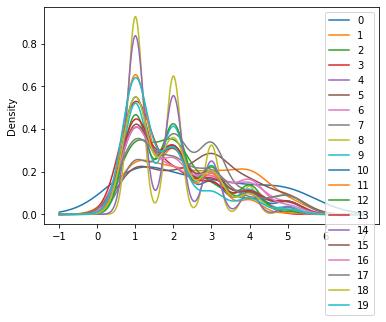

In [18]:
df.groupby("G")['age'].plot(kind='density')
plt.legend()

Not very useful, but easy to do if "G" is of a smaller dimension

Now to introduce two functions: value_counts and nunique, both useful for analysis with groupby and answering basic question about the data.

For example: how many cows are we looking at?

In [19]:
df['i'].nunique()

3493

how many herds?

In [20]:
df['G'].nunique()

20

over how many years?

In [21]:
df['year_of_calving'].nunique()

4

How about a summary stat table summing all of this up?

Easy!

In [22]:
# just call that function and it applies it to each column
counttable = df[['i','G','year_of_calving']].nunique()

# Thats a series, but I want column labels so I convert to dataframe
counttable = pd.DataFrame(counttable)

counttable.index = ["Cows",'Herds',"Years"]
counttable.columns = ["Counts"]
counttable

Counts
Cows     3493
Herds      20
Years       4

#### But how many cows are in each herd?
Use nunique with groupby:

In [23]:
df.groupby("G")['i'].nunique()

G
0        8
1       31
2       45
3       30
4      119
5       35
6       73
7       33
8     1325
9      190
10     182
11      67
12     135
13     107
14     654
15      82
16      87
17      83
18     122
19      85
Name: i, dtype: int64

But how many cows do we have at each age? That's easiest to calculate with value_counts, which gives the total number of instances of each value:

In [24]:
df['age'].value_counts()

1    4376
2    2992
3    1599
4     793
5     298
Name: age, dtype: int64

Notice how easy it is to plot this as a bar graph:

Text(0.5, 1.0, 'Distribution of Ages')

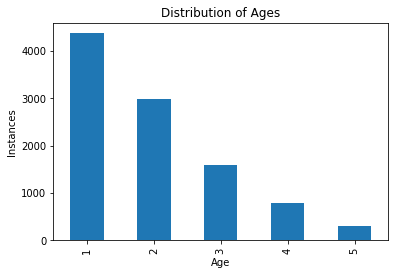

In [25]:
df['age'].value_counts().plot(kind='bar')
plt.xlabel("Age")
plt.ylabel("Instances")
plt.title("Distribution of Ages")

### Merges

Suppose we would like to use herd size as a covariate. We can use the above to get a dataframe of numbers of unique "i" for every "G," but now we need to merge it in.

In [26]:
# First herd size:
herdsizes = df.groupby(["G"])['i'].nunique().reset_index()
# I call reset_index() to make sure that "G" is still a column, as after
# using a groupby it will store the group as the index (you have to reset_index() in
# order to call it as a column.

# Renaming column, as by default it is just "i"
herdsizes.columns = ['G','herd_size']
herdsizes

G  herd_size
0    0          8
1    1         31
2    2         45
3    3         30
4    4        119
5    5         35
6    6         73
7    7         33
8    8       1325
9    9        190
10  10        182
11  11         67
12  12        135
13  13        107
14  14        654
15  15         82
16  16         87
17  17         83
18  18        122
19  19         85

In [27]:
# Doing a merge, we want to merge "left," on the column "G"
df.merge(herdsizes,how="left",on="G").head()

G     i  fat_yield  age  cycle_length  test_date month_of_calving  \
0  19  3923      770.0    5           283 2013-06-04                8   
1  19  3923      744.0    4           290 2012-04-04                6   
2  19  3923      827.0    5           311 2013-07-02                8   
3  19  3923      795.0    4           319 2012-05-03                6   
4  19  3923      887.0    5           342 2013-08-02                8   

  date_of_calving  milked_3x year_of_calving  herd_size  
0      2012-08-25        0.0            2012         85  
1      2011-06-19        0.0            2011         85  
2      2012-08-25        0.0            2012         85  
3      2011-06-19        0.0            2011         85  
4      2012-08-25        0.0            2012         85

Notice we now have a new column, which is "herd_size." There is only one value per G, which is why we did a left merge (other options are "right," "inner," and "outer").

Here's an example of an "inner" and "outer" merge (only keeps rows in both data sets or includes rows from both). Pretend we have df1 which only has milked_3x info for 2011 and the rest of the data for yield:

In [28]:
# A combination of i and test_date uniquely identifies rows of data

# pretend these were two different datasets
df1 = df[df.year_of_calving=='2011'][['i','test_date','milked_3x']]
df2 = df[['i','test_date','fat_yield']]

inner_merged_df = df1.merge(df2,how='inner',on=['i','test_date'])
inner_merged_df.shape

(2046, 4)

only contains 2000 records since it is just 2011. Here is an outer merge:

In [29]:
outer_merged_df = df1.merge(df2,how='outer',on=['i','test_date'])
outer_merged_df.tail()

i  test_date  milked_3x  fat_yield
10053   9 2014-11-03        NaN     1095.0
10054   9 2014-12-08        NaN     1163.0
10055  10 2013-09-09        NaN      752.0
10056  11 2014-09-08        NaN      730.0
10057  11 2014-10-06        NaN      792.0

Note there is the same amount of rows as the main data but anything beyond 2011 is now missing.

#### Exercise: the calculation I did above was wrong. It should be grouped by both year_of_calving and G. Do this calculation, and call the new column "herd_size_by_year"

In [30]:
# Solution
herdsize_by_year = df.groupby(['G','year_of_calving'])['i'].nunique().reset_index()
herdsize_by_year.columns = ['G','year_of_calving','herd_size_by_year']

# Notice in this merge, I've ommitted the "on" arguments; it will automatically look for the columns 
# the two have in common and do a merge on those.
df = df.merge(herdsize_by_year,how='left')
df.head()

G     i  fat_yield  age  cycle_length  test_date month_of_calving  \
0  19  3923      770.0    5           283 2013-06-04                8   
1  19  3923      744.0    4           290 2012-04-04                6   
2  19  3923      827.0    5           311 2013-07-02                8   
3  19  3923      795.0    4           319 2012-05-03                6   
4  19  3923      887.0    5           342 2013-08-02                8   

  date_of_calving  milked_3x year_of_calving  herd_size_by_year  
0      2012-08-25        0.0            2012                 39  
1      2011-06-19        0.0            2011                 22  
2      2012-08-25        0.0            2012                 39  
3      2011-06-19        0.0            2011                 22  
4      2012-08-25        0.0            2012                 39

## Data Analysis

### Exercise 1: Make the following tables
- Summary statistics (mean and std dev) of yield and milked_3x in the data.
- Graph of distribution of herd_size_by_year.
- Table of average of yield and milked_3x by herd.

### Exercise 2: Regression analysis
- Estimate the "age of max production" in a production function.
    - Need a regression of the form $y_{it} = \beta_1 a_{it} + \beta_2 a^2_{it} + \gamma X_{it} + \epsilon_{it}$, where $X$ is a vector of confounding factors to control for.
    - Note: the max for a quadratic function is: -$\beta_1/2\beta_2$.
    - Control variables could include: herd fixed effect, milked_3x, year or month of calving, cycle length, ect.


### Solution to Exercise 1

In [31]:
summary_stats = df[['fat_yield','milked_3x']].describe()
summary_stats = summary_stats.T[['mean','std']]
summary_stats.index = ['Fat Yield','Milked 3x']
summary_stats.columns = ['Mean','Standard Deviation']
summary_stats.round(2)

Mean  Standard Deviation
Fat Yield  936.03              193.52
Milked 3x    0.61                0.49

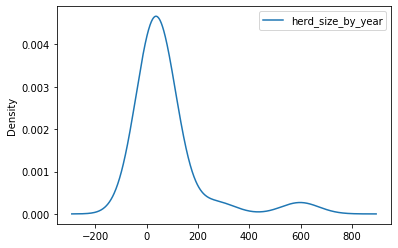

In [32]:
# Lot of ways you could do this, but easiest is just a kernel density

# Herd size averaged over time graphed:
df.groupby('G')['herd_size_by_year'].mean().plot(kind='density')
plt.legend()

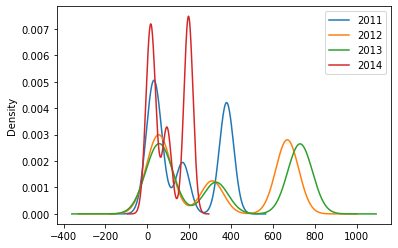

In [33]:
# Average herd size by year
df.groupby('year_of_calving')['herd_size_by_year'].plot(kind='density')
plt.legend()

In [34]:
# Advanced way: this graph is not so informative, we should bin them and do a histogram.
# Introducing the "cut" function from pandas

pd.cut(df.groupby('G')['herd_size_by_year'].mean(),[0,50,100,250,500,1000])

G
0         (0, 50]
1         (0, 50]
2         (0, 50]
3         (0, 50]
4         (0, 50]
5         (0, 50]
6         (0, 50]
7         (0, 50]
8     (500, 1000]
9       (50, 100]
10      (50, 100]
11        (0, 50]
12      (50, 100]
13        (0, 50]
14     (250, 500]
15        (0, 50]
16        (0, 50]
17        (0, 50]
18      (50, 100]
19        (0, 50]
Name: herd_size_by_year, dtype: category
Categories (5, interval[int64]): [(0, 50] < (50, 100] < (100, 250] < (250, 500] < (500, 1000]]

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

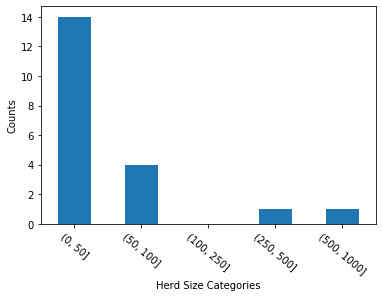

In [35]:
# This function makes a categorical variable out of a continuous variable given the levels at which I ask it to cut.

# Now use the same trick as I did before with value_counts and a bar graph
pd.cut(df.groupby('G')['herd_size_by_year'].mean(),[0,50,100,250,500,1000]).value_counts().sort_index().plot(kind='bar')
plt.xlabel("Herd Size Categories")
plt.ylabel("Counts")
plt.xticks(rotation=-40)


In [36]:
# Final table
df.groupby("G")[['milked_3x','fat_yield']].apply(np.mean)

milked_3x    fat_yield
G                         
0    0.000000   808.583333
1    0.000000   723.415094
2    0.000000   952.782353
3    0.005123   685.418605
4    0.000000   923.262626
5    0.000000   848.424779
6    0.000000   603.829167
7    0.000000   972.172414
8    0.999575   928.709736
9    0.000000   972.847902
10   1.000000  1018.260956
11   0.000000   943.310000
12   0.000000   974.664850
13   0.000000   901.909091
14   1.000000  1039.030477
15   0.000000   755.466216
16   0.000000   981.791391
17   0.000000   901.460396
18   0.000000   893.115607
19   0.000000   820.628141

### Exercise 2: Solution

In [37]:
from statsmodels.formula.api import ols
df['age_sqrd'] = df['age']**2

formula = "fat_yield ~ age + age_sqrd +milked_3x +cycle_length + G + C(year_of_calving) +month_of_calving"
# cov_type = HC3 gives robust standard errors
model = ols(formula=formula,data=df).fit(cov_type='HC3')
model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fat_yield   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     301.2
Date:                Wed, 31 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:21:34   Log-Likelihood:                -63688.
No. Observations:               10058   AIC:                         1.275e+05
Df Residuals:                   10020   BIC:                         1.277e+05
Df Model:                          37                                         
Covariance Type:                  HC3                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -391.7369     27.442    -14.275      0.000    -445.523    -337.951
G[T.1]                      -123.7352     20.050     -6.171      0.000    -163.032     -84.438
G[T.2]                       132.7937     22.587      5.879      0.000      88.525     177.062
G[T.3]                      -112.9312     24.978     -4.521      0.000    -161.887     -63.975
G[T.4]                       131.2110     19.821      6.620      0.000      92.362     170.060
G[T.5]                         9.3372     23.370      0.400      0.689     -36.466      55.141
G[T.6]                      -204.4574     19.677    -10.391      0.000    -243.023    -165.892
G[T.7]                       124.1054     23.590      5.261      0.000      77.871     170.340
G[T.8]                       -76.0437    233.565     -0.326      0.745    -533.823     381.736
G[T.9]                       156.2782     19.376      8.066      0.000     118.302     194.254
G[T.10]                       13.1011    233.711      0.056      0.955    -444.964     471.166
G[T.11]                      151.0212     20.293      7.442      0.000     111.248     190.795
G[T.12]                      164.1834     20.024      8.199      0.000     124.937     203.429
G[T.13]                       94.5241     19.501      4.847      0.000      56.303     132.745
G[T.14]                       41.3380    233.687      0.177      0.860    -416.680     499.356
G[T.15]                      -63.7914     19.414     -3.286      0.001    -101.843     -25.740
G[T.16]                      159.7234     19.910      8.022      0.000     120.701     198.745
G[T.17]                       92.9953     20.278      4.586      0.000      53.250     132.740
G[T.18]                       92.9627     20.100      4.625      0.000      53.568     132.358
G[T.19]                       45.9688     19.635      2.341      0.019       7.485      84.453
C(year_of_calving)[T.2012]    35.6876      4.013      8.894      0.000      27.823      43.552
C(year_of_calving)[T.2013]    19.7268      3.979      4.958      0.000      11.929      27.525
C(year_of_calving)[T.2014]    21.9425      7.184      3.054      0.002       7.862      36.023
month_of_calving[T.2]         -3.4840      7.016     -0.497      0.619     -17.235      10.267
month_of_calving[T.3]        -10.6817      7.210     -1.482      0.138     -24.813       3.449
month_of_calving[T.4]         -8.0778      7.767     -1.040      0.298     -23.301       7.145
month_of_calving[T.5]        -25.3035      6.907     -3.664      0.000     -38.840     -11.766
month_of_calving[T.6]        -18.3175      6.690     -2.738      0.006     -31.431      -5.204
month_of_calving[T.7]        -14.8877      6.798     -2.190      0.029     -28.212      -1.563
month_of_calving[T.8]        -16.3341      

In [38]:
-model.params['age']/(model.params['age_sqrd']*2)

3.521826696244845

So the cycle at which production is maximized is about 3.

#### Notice:
- I only needed to call the C() function in the formula on variables not already specified as factors. Because I specified the others as categoricals, it automatically treated them as factors in the formula.
- I can use the "params" part of the model object to just get the parameters by themselves.